In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from opera_tropo.config import pge_runconfig
from opera_tropo.log.loggin_setup import setup_logging, log_runtime
from opera_tropo.utils import get_hres_datetime, get_max_memory_usage

In [51]:
import numpy as np
import xarray as xr

from opera_tropo.product_info import TROPO_PRODUCTS, GLOBAL_ATTRS
from opera_tropo.utils import round_mantissa

# NOTE: check if it is better to add attributes at the end to
#       leave this empty and more light

def pack_ztd(wet_ztd: np.ndarray, hydrostatic_ztd: np.ndarray,
             lons: np.ndarray, lats: np.ndarray,
             zs: np.ndarray, model_time: np.ndarray,
             chunk_size={"longitude": 128, "latitude": 128,
                         "height": -1, "time": 1},
             keep_bits: int = True):
    """
    Package Zenith Total Delay (ZTD) data into an xarray Dataset.

    Parameters:
    - wet_ztd (array-like): Array of wet zenith total delays.
    - hydrostatic_ztd (array-like): Array of hydrostatic zenith total delays.
    - lons (array-like): Array of longitudes.
    - lats (array-like): Array of latitudes.
    - zs (array-like): Array of heights.
    - model_time (array-like): Array of model times.
    - chunk_size (dict): Chunk size for the dataset.

    Returns:
    - ds (xarray.Dataset): Packaged ZTD data.
    """

    dim = ["height", "latitude", "longitude"]
    reference_time = model_time.astype('datetime64[s]').astype('O')[0]
    reference_time = reference_time.strftime('%Y-%m-%d %H:%M:%S')   

    #zenith_delay = hydrostatic_ztd + wet_ztd 
    wet_ztd = wet_ztd.astype(TROPO_PRODUCTS.wet_delay.dtype)
    hydrostatic_ztd = hydrostatic_ztd.astype(TROPO_PRODUCTS.hydrostatic_delay.dtype) 
    
    zs = zs.astype('float32')

    # Rounding
    if keep_bits:
        if TROPO_PRODUCTS.wet_delay.keep_bits:
            round_mantissa(wet_ztd,
                           keep_bits=int(TROPO_PRODUCTS.wet_delay.keep_bits))
        if TROPO_PRODUCTS.hydrostatic_delay.keep_bits:
            print(int(TROPO_PRODUCTS.hydrostatic_delay.keep_bits))
            round_mantissa(hydrostatic_ztd,
                            keep_bits=int(TROPO_PRODUCTS.hydrostatic_delay.keep_bits))

    ds = xr.Dataset(
        data_vars=dict(
            wet_delay=(dim, wet_ztd.transpose(2, 0, 1),
                       TROPO_PRODUCTS.wet_delay.to_dict()),
            hydrostatic_delay=(dim, hydrostatic_ztd.transpose(2, 0, 1),
                               TROPO_PRODUCTS.hydrostatic_delay.to_dict()), 
        ),
        # normalizing longitudes to the range [-180, 180] from [0, 360]
        coords=dict(longitude=(np.float64(lons) + 180) % 360 - 180, 
                    latitude=np.float64(lats), 
                    height=np.float64(zs)),
        attrs=GLOBAL_ATTRS | {"reference_time": reference_time}
    )
    
    # Add coords attrs
    ds['height'].attrs.update(TROPO_PRODUCTS.coords.height.get_attr)
    ds['latitude'].attrs.update(TROPO_PRODUCTS.coords.latitude.get_attr)
    ds['longitude'].attrs.update(TROPO_PRODUCTS.coords.longitude.get_attr)
    
    # Add time
    ds = ds.expand_dims({"time": model_time})
    ds['time'].attrs.update(TROPO_PRODUCTS.coords.time.get_attr)
    # Remove time units due to conflicts with encoding
    del ds['time'].attrs['units']
    ds['time'].encoding.update(TROPO_PRODUCTS.coords.time.encoding)

    # Add spatial reference
    ds.rio.write_crs("EPSG:4326", inplace=True)

    # Data Variables
    wet_fill = TROPO_PRODUCTS.wet_delay.fillvalue
    hydro_fill = TROPO_PRODUCTS.hydrostatic_delay.fillvalue
    ds["wet_delay"].attrs["_FillValue"] = wet_fill 
    ds["hydrostatic_delay"].attrs["_FillValue"] = hydro_fill 

    # Add chunks to data variables
    if chunk_size is not None:
        for key in ["wet_delay", "hydrostatic_delay"]:#, "zenith_total_delay"]:
            ds[key] = ds[key].chunk(chunk_size)

        # Ensure that chunking is applied to the entire dataset
        ds = ds.chunk(chunk_size)

    return ds

In [52]:
from __future__ import annotations

import numpy as np
import logging
import xarray as xr
from opera_tropo.log.loggin_setup import log_runtime

from RAiDER.models import HRES

logger = logging.getLogger(__name__)

# NOTE: I could add interpolation to specific height levels here
#       to lower the resolution of the data, and its memory footprint during processing
#       but I will leave that for a future performance tests
@log_runtime
def calculate_ztd(da: xr.Dataset, out_heights: list = [],
                  chunk_size=None, keep_bits:bool=True) -> xr.Dataset:
        """Calculate Zenith Total Delay (ZTD) using HRES weather model data."""
        hres_model = HRES()

        # Extract temperature and specific humidity at the first time step
        hres_model._t = da.t.isel(time=0).values
        hres_model._q = da.q.isel(time=0).values

        # Extract longitude and latitude values
        longitude = da.longitude.values
        latitude = da.latitude.values

        # Use geopotential heights and log of surface pressure
        # to get pressure, geopotential, and geopotential height
        _, pres, hgt = hres_model._calculategeoh(
                da.z.isel(time=0, level=0).values,
                da.lnsp.isel(time=0, level=0).values
        )
        hres_model._p = pres

        # Create latitude and longitude grid
        hres_model._lons, hres_model._lats = np.meshgrid(longitude, latitude)

        # Get altitudes
        hres_model._get_heights(hres_model._lats, hgt.transpose(1, 2, 0))
        h = hres_model._zs.copy()

        # Re-structure arrays from (heights, lats, lons) to (lons, lats, heights)
        hres_model._p = np.flip(hres_model._p.transpose(1, 2, 0), axis=2)
        hres_model._t = np.flip(hres_model._t.transpose(1, 2, 0), axis=2)
        hres_model._q = np.flip(hres_model._q.transpose(1, 2, 0), axis=2)
        hres_model._zs = np.flip(h, axis=2)
        hres_model._xs, hres_model._ys = hres_model._lons.copy(), hres_model._lats.copy()

        # Perform RAiDER computations
        hres_model._find_e()  # Compute partial pressure of water vapor
        hres_model._uniform_in_z(_zlevels=None)

        hres_model._checkForNans()
        hres_model._get_wet_refractivity()
        hres_model._get_hydro_refractivity()
        hres_model._adjust_grid(hres_model.get_latlon_bounds())

        # Compute zenith delays at the weather model grid nodes
        hres_model._getZTD()

        # Package ztd
        ztd_xr = pack_ztd(
                hres_model._wet_ztd,
                hres_model._hydrostatic_ztd,
                longitude,
                latitude,
                hres_model._zs,
                da.time.data,
                chunk_size=chunk_size,
                keep_bits=keep_bits,
        )
        # Do some cleanup
        del hres_model, longitude, latitude, h, pres, hgt

        # Interpolate
        if out_heights is not None and len(out_heights) > 1:
            ztd_xr = ztd_xr.interp(height=out_heights,
                                   method='cubic')

        return ztd_xr

In [6]:
work_dir = Path('/u/aurora-r0/govorcin/01_OPERA/TROPO/interface/data/')

In [55]:
import xarray as xr
ds = xr.open_dataset(work_dir / 'D06130000061300001.zz.nc',
                     chunks={})

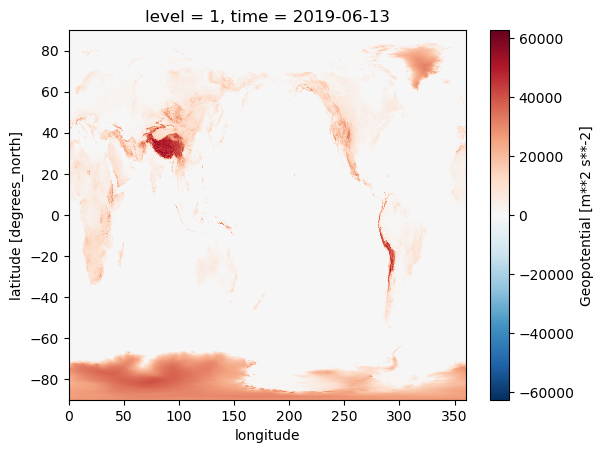

In [4]:
ds.isel(time=0, level=0).z.plot.imshow()

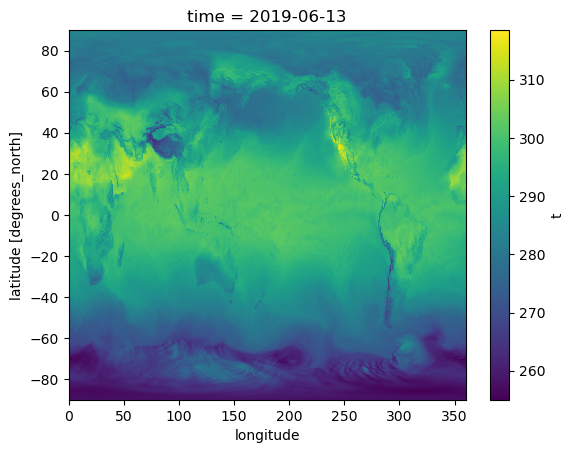

In [204]:
ds.isel(time=0).t.max(dim='level').plot.imshow()

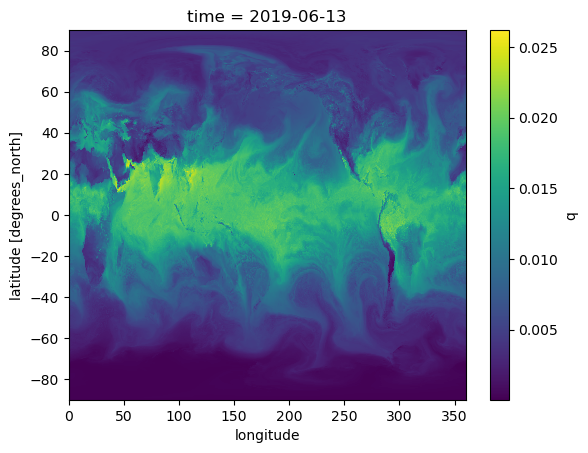

In [203]:
ds.isel(time=0).q.max(dim='level').plot.imshow()

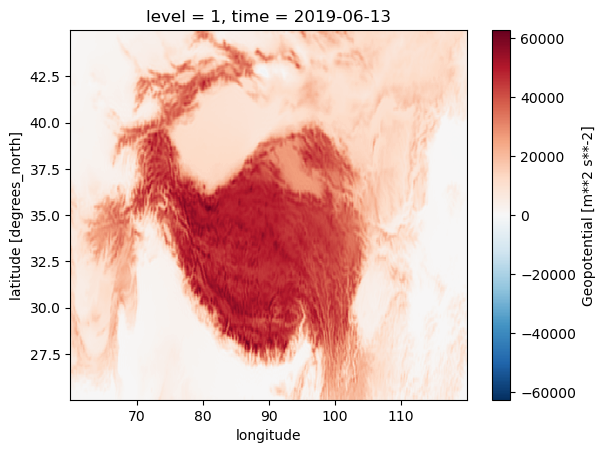

In [6]:
ds.isel(level=0, time=0).sel(latitude=slice(45, 25), longitude=slice(60, 120)).z.plot.imshow()

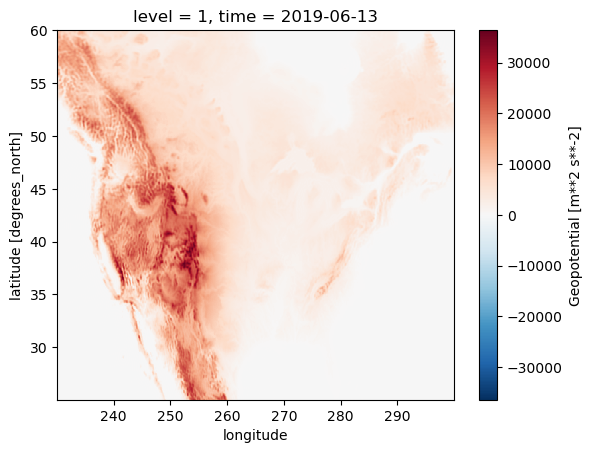

In [196]:
ds.isel(level=0, time=0).sel(latitude=slice(60, 25), longitude=slice(230, 300)).z.plot.imshow()

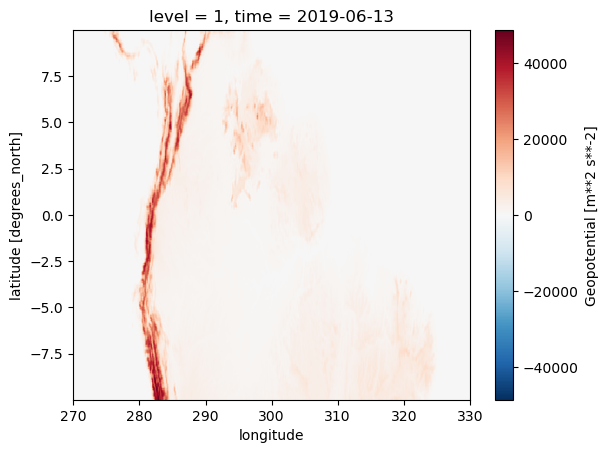

In [207]:
ds.isel(level=0, time=0).sel(latitude=slice(10, -10), longitude=slice(270, 330)).z.plot.imshow()

In [208]:
subset_ds = ds.sel(latitude=slice(40, 25), longitude=slice(60, 110))
subset_ds2 = ds.sel(latitude=slice(60, 25), longitude=slice(230, 300))
subset_ds3 = ds.sel(latitude=slice(10, -10), longitude=slice(270, 330))
#subset_ds4 = ds.sel(latitude=slice(60, 25), longitude=slice(230, 300))

In [13]:
subset_ds

<xarray.Dataset> Size: 332MB
Dimensions:    (time: 1, level: 137, latitude: 213, longitude: 711)
Coordinates:
  * longitude  (longitude) float32 3kB 60.05 60.12 60.19 ... 109.8 109.9 110.0
  * latitude   (latitude) float32 852B 39.96 39.89 39.82 ... 25.2 25.13 25.06
  * level      (level) int32 548B 1 2 3 4 5 6 7 ... 131 132 133 134 135 136 137
  * time       (time) datetime64[ns] 8B 2019-06-13
Data variables:
    z          (time, level, latitude, longitude) float32 83MB dask.array<chunksize=(1, 28, 213, 170), meta=np.ndarray>
    t          (time, level, latitude, longitude) float32 83MB dask.array<chunksize=(1, 28, 213, 170), meta=np.ndarray>
    q          (time, level, latitude, longitude) float32 83MB dask.array<chunksize=(1, 28, 213, 170), meta=np.ndarray>
    lnsp       (time, level, latitude, longitude) float32 83MB dask.array<chunksize=(1, 28, 213, 170), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2024-12-11 19:08:29 GMT by grib_to_netcdf-2.28.1: grib_to_n...

# Compare rounding results

In [8]:
import pandas as pd
from matplotlib.colors import TwoSlopeNorm
from collections import namedtuple
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

# Define base namedtuple
_round_stat = namedtuple('test', ['min', 'mean', 'max'])

def get_rounding_precision(ds1, ds2, layer):
    # Create a new namedtuple class with a dynamic typename
    RoundStat = namedtuple(layer, _round_stat._fields)
    
    # Compute values and instantiate the namedtuple
    round_stat_instance = RoundStat(
        min=(ds1[layer] - ds2[layer]).min().values.item(),
        mean=(ds1[layer] - ds2[layer]).mean().values.item(),  
        max=(ds1[layer] - ds2[layer]).max().values.item() 
    )
    
    return round_stat_instance

# Crosstab 

def get_cross_tab(ds_dict,
                  labels=['6', '8', '10', '12', '14', 'no'],
                  layer='wet_delay',
                  metric='min'):
    in_dict = dict((key, None) for key in labels)
    out_dict = dict((key, in_dict.copy()) for key in labels) 

    for key1 in labels:
        for key2 in labels:
            if metric == 'min':
               out_dict[key1][key2] = get_rounding_precision(ds_dict[key1], ds_dict[key2], layer).min 
            elif metric == 'max':
               out_dict[key1][key2] = get_rounding_precision(ds_dict[key1], ds_dict[key2], layer).max
            elif metric == 'mean':
               out_dict[key1][key2] = get_rounding_precision(ds_dict[key1], ds_dict[key2], layer).mean
    return pd.DataFrame(out_dict)


def _plot_crosstab(fig, ax, df, layer='wet_delay'):
    # Plot heatmap using imshow()
    df *= 1e3
    norm = TwoSlopeNorm(vmin=df.min().min()-1e-10, vcenter=0, vmax=df.max().max()+1e-10)
    cax = ax.imshow(df.values, cmap="coolwarm", aspect="auto", alpha=0.6, norm=norm)

    # Add colorbar
    cbar = fig.colorbar(cax, ax=ax)
    cbar.set_label("mm")

    # Add numbers inside each cell
    for i in range(df.shape[0]):  # Iterate over rows
        for j in range(df.shape[1]):  # Iterate over columns
            text = f"{df.iloc[i, j]:.3f}"  # Format number to 5 decimal places
            
            # Set font to bold for last row or column
            font = 'bold' if (i == df.shape[0] - 1) or (j == df.shape[1] - 1) else 'normal'
            
            # Add the text inside each cell
            ax.text(j, i, text, ha="center", va="center", color="black", weight=font, fontsize=10)



    # Add gridlines
    ax.set_xticks(np.arange(df.shape[1] + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(df.shape[0] + 1) - 0.5, minor=True)
    ax.set_xticklabels(np.append('0',df.columns))
    ax.set_yticklabels(np.append('0', df.index))
    ax.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
    ax.set_xlabel('bits')
    ax.set_ylabel('bits')
    # Hide the minor ticks to only show the grid
    ax.tick_params(which="minor", size=0)

    # Rotate x-axis labels for better readability
    ax.set_title(f'{layer} rounding diff.')

    return ax

In [25]:
%%time
TROPO_PRODUCTS.wet_delay.keep_bits = 6
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 6
out_ds_6 = calculate_ztd(subset_ds)

6
CPU times: user 30.4 s, sys: 23.5 s, total: 53.9 s
Wall time: 52.8 s


In [24]:
%%time
TROPO_PRODUCTS.wet_delay.keep_bits = 8
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 8
out_ds_8 = calculate_ztd(subset_ds)

In [22]:
%%time
TROPO_PRODUCTS.wet_delay.keep_bits = 10
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 10
out_ds_10 = calculate_ztd(subset_ds)

10
CPU times: user 30.5 s, sys: 22.8 s, total: 53.3 s
Wall time: 52.1 s


In [26]:
%%time
TROPO_PRODUCTS.wet_delay.keep_bits = 12
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 12
out_ds_12 = calculate_ztd(subset_ds)

12
CPU times: user 30.3 s, sys: 22.2 s, total: 52.4 s
Wall time: 51.2 s


In [27]:
%%time
TROPO_PRODUCTS.wet_delay.keep_bits = 14
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 14
out_ds_14 = calculate_ztd(subset_ds)

14
CPU times: user 31 s, sys: 23.1 s, total: 54 s
Wall time: 53.1 s


In [181]:
%%time
out_ds = calculate_ztd(subset_ds, keep_bits=False)

CPU times: user 32.3 s, sys: 23.1 s, total: 55.4 s
Wall time: 54.3 s


In [183]:
# Get different round results
ds_dict = {'6': out_ds_6,
          '8': out_ds_8,
          '10': out_ds_10,
          '12': out_ds_12,
          '14': out_ds_14,
          'no': out_ds}

Text(0.5, 0.98, 'Wet_delay')

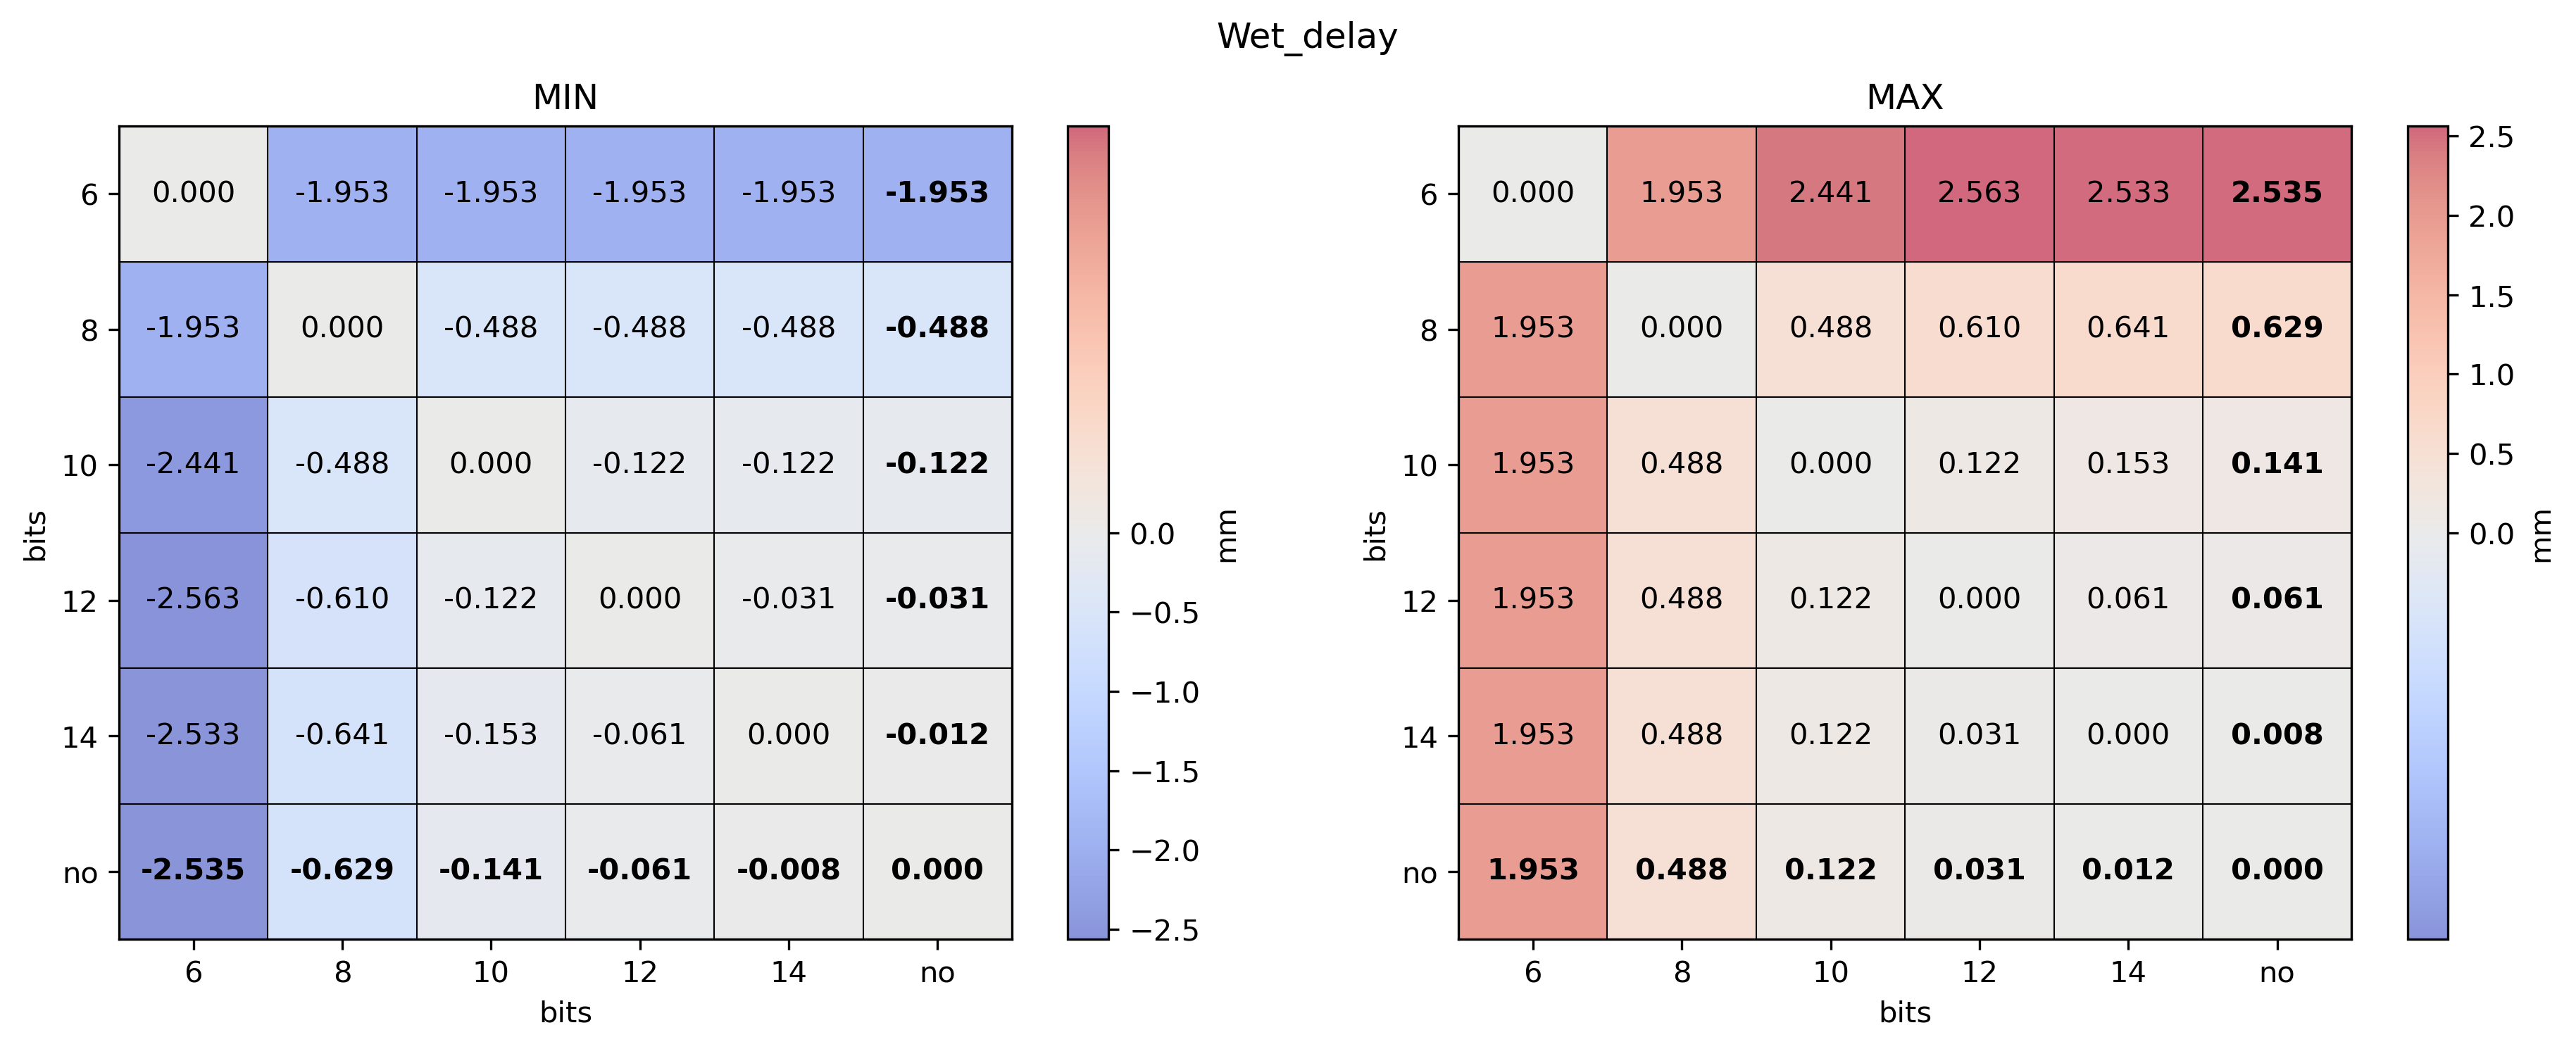

In [192]:
df_min = get_cross_tab(ds_dict, metric='min', layer='wet_delay')
df_max = get_cross_tab(ds_dict, metric='max', layer='wet_delay')
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=300)
ax[0] = _plot_crosstab(fig, ax[0], df_min), ax[0].set_title('MIN')
ax[1] = _plot_crosstab(fig, ax[1], df_max), ax[1].set_title('MAX')
fig.suptitle('Wet_delay')

Text(0.5, 0.98, 'hydrostatic_delay')

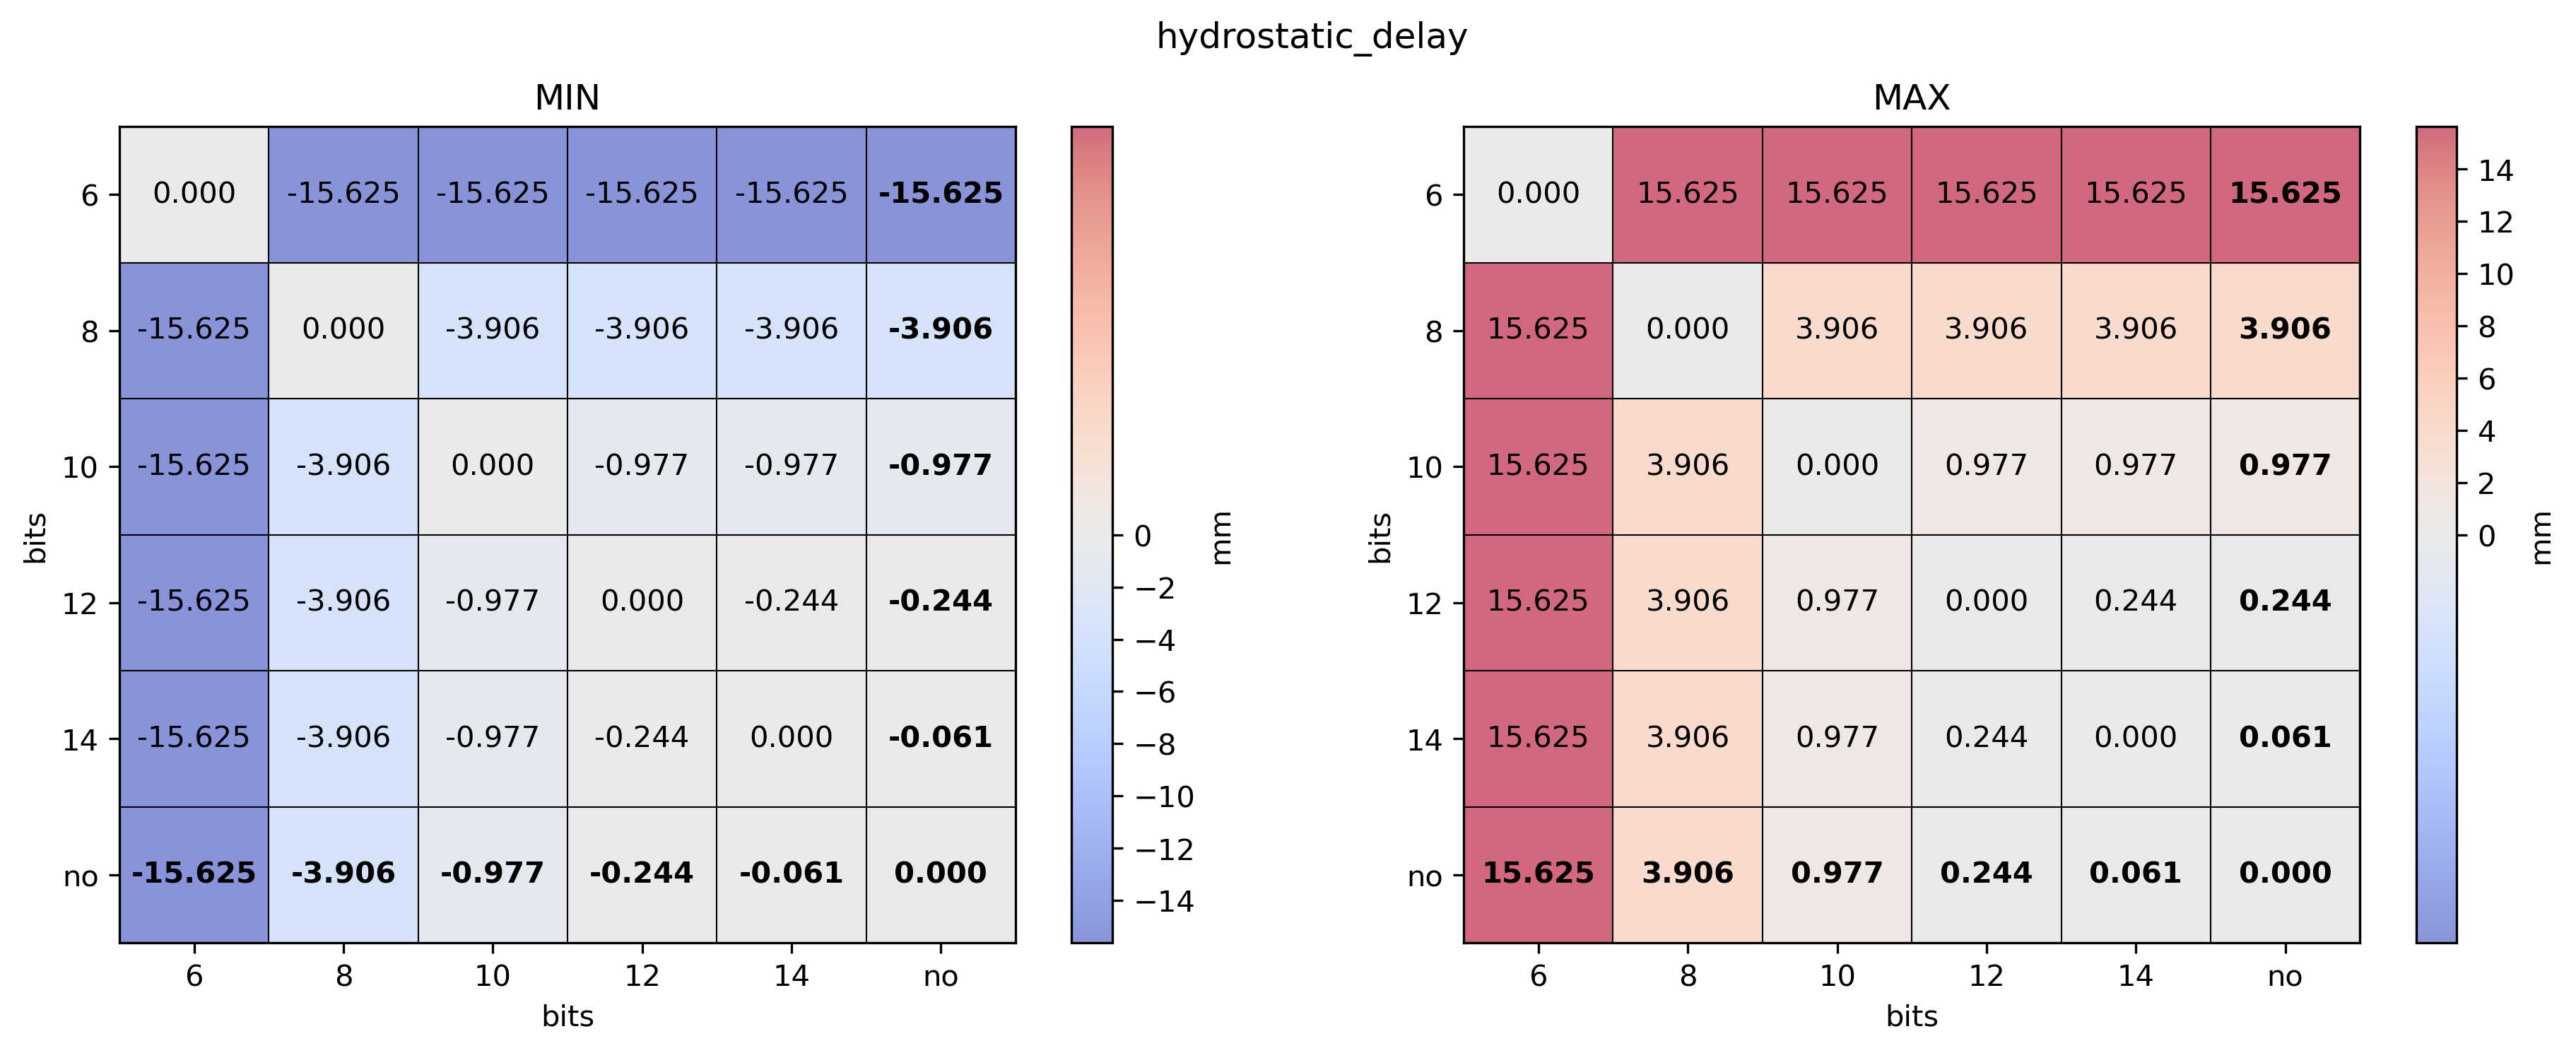

In [193]:
df_min = get_cross_tab(ds_dict, metric='min', layer='hydrostatic_delay')
df_max = get_cross_tab(ds_dict, metric='max', layer='hydrostatic_delay')
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=300)
ax[0] = _plot_crosstab(fig, ax[0], df_min), ax[0].set_title('MIN')
ax[1] = _plot_crosstab(fig, ax[1], df_max), ax[1].set_title('MAX')
fig.suptitle('hydrostatic_delay')

In [198]:
%%time
TROPO_PRODUCTS.wet_delay.keep_bits = 6
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 6
out_ds_6 = calculate_ztd(subset_ds2)

TROPO_PRODUCTS.wet_delay.keep_bits = 8
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 8
out_ds_8 = calculate_ztd(subset_ds2)

TROPO_PRODUCTS.wet_delay.keep_bits = 10
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 10
out_ds_10 = calculate_ztd(subset_ds2)

TROPO_PRODUCTS.wet_delay.keep_bits = 12
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 12
out_ds_12 = calculate_ztd(subset_ds2)

TROPO_PRODUCTS.wet_delay.keep_bits = 14
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 14
out_ds_14 = calculate_ztd(subset_ds2)

out_ds = calculate_ztd(subset_ds2, keep_bits=False)

# Get different round results
ds_dict = {'6': out_ds_6,
          '8': out_ds_8,
          '10': out_ds_10,
          '12': out_ds_12,
          '14': out_ds_14,
          'no': out_ds}

6
8
10
12
14
CPU times: user 9min 1s, sys: 8min 13s, total: 17min 15s
Wall time: 16min 59s


Text(0.5, 0.98, 'Wet_delay')

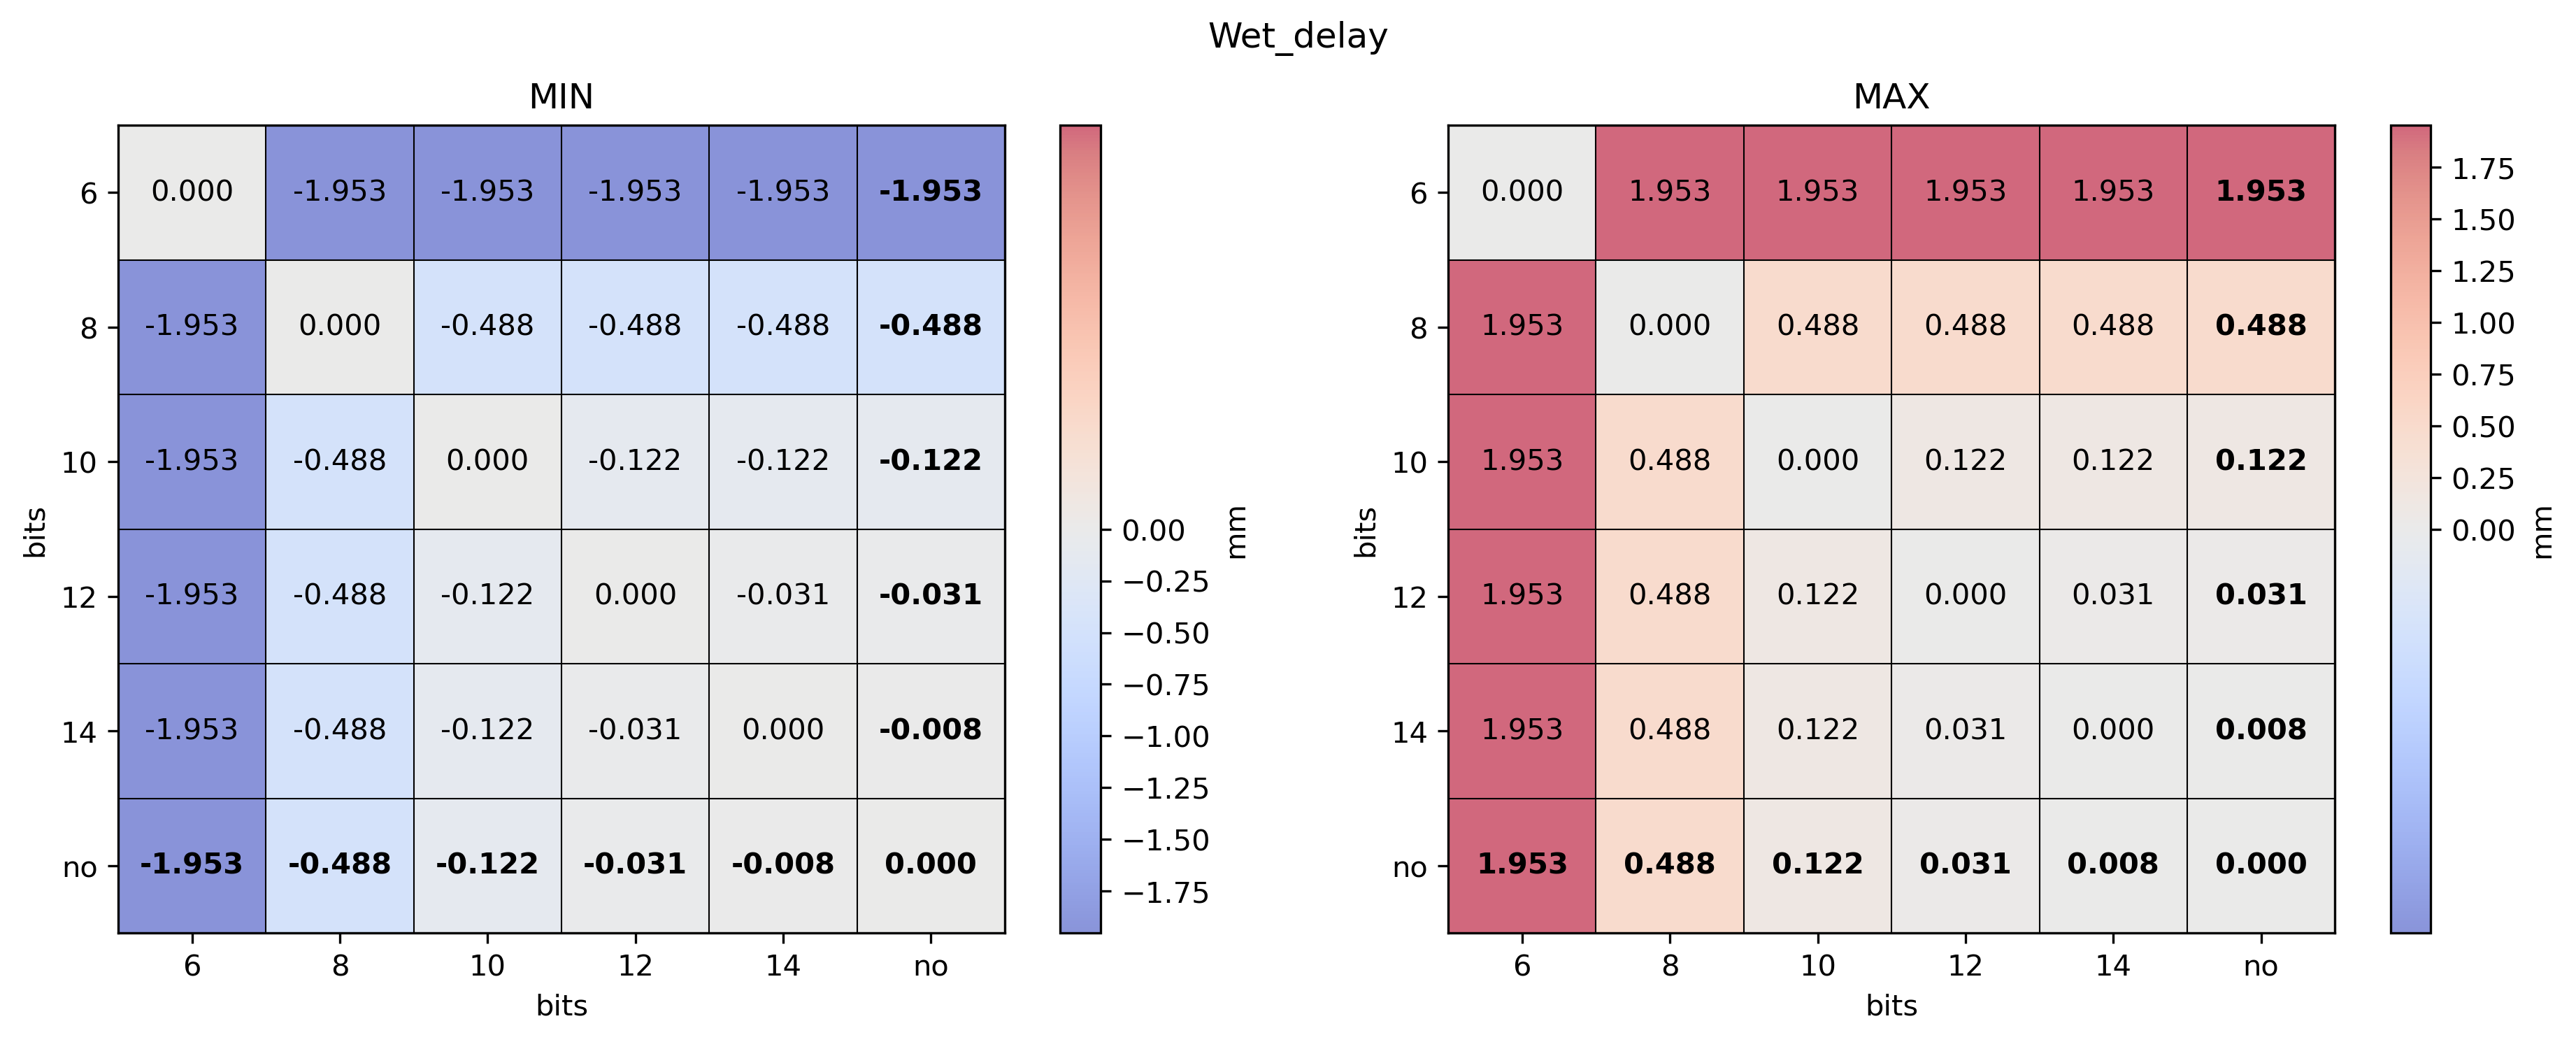

In [200]:
df_min = get_cross_tab(ds_dict, metric='min', layer='wet_delay')
df_max = get_cross_tab(ds_dict, metric='max', layer='wet_delay')
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=300)
ax[0] = _plot_crosstab(fig, ax[0], df_min), ax[0].set_title('MIN')
ax[1] = _plot_crosstab(fig, ax[1], df_max), ax[1].set_title('MAX')
fig.suptitle('Wet_delay')

Text(0.5, 0.98, 'hydrostatic_delay')

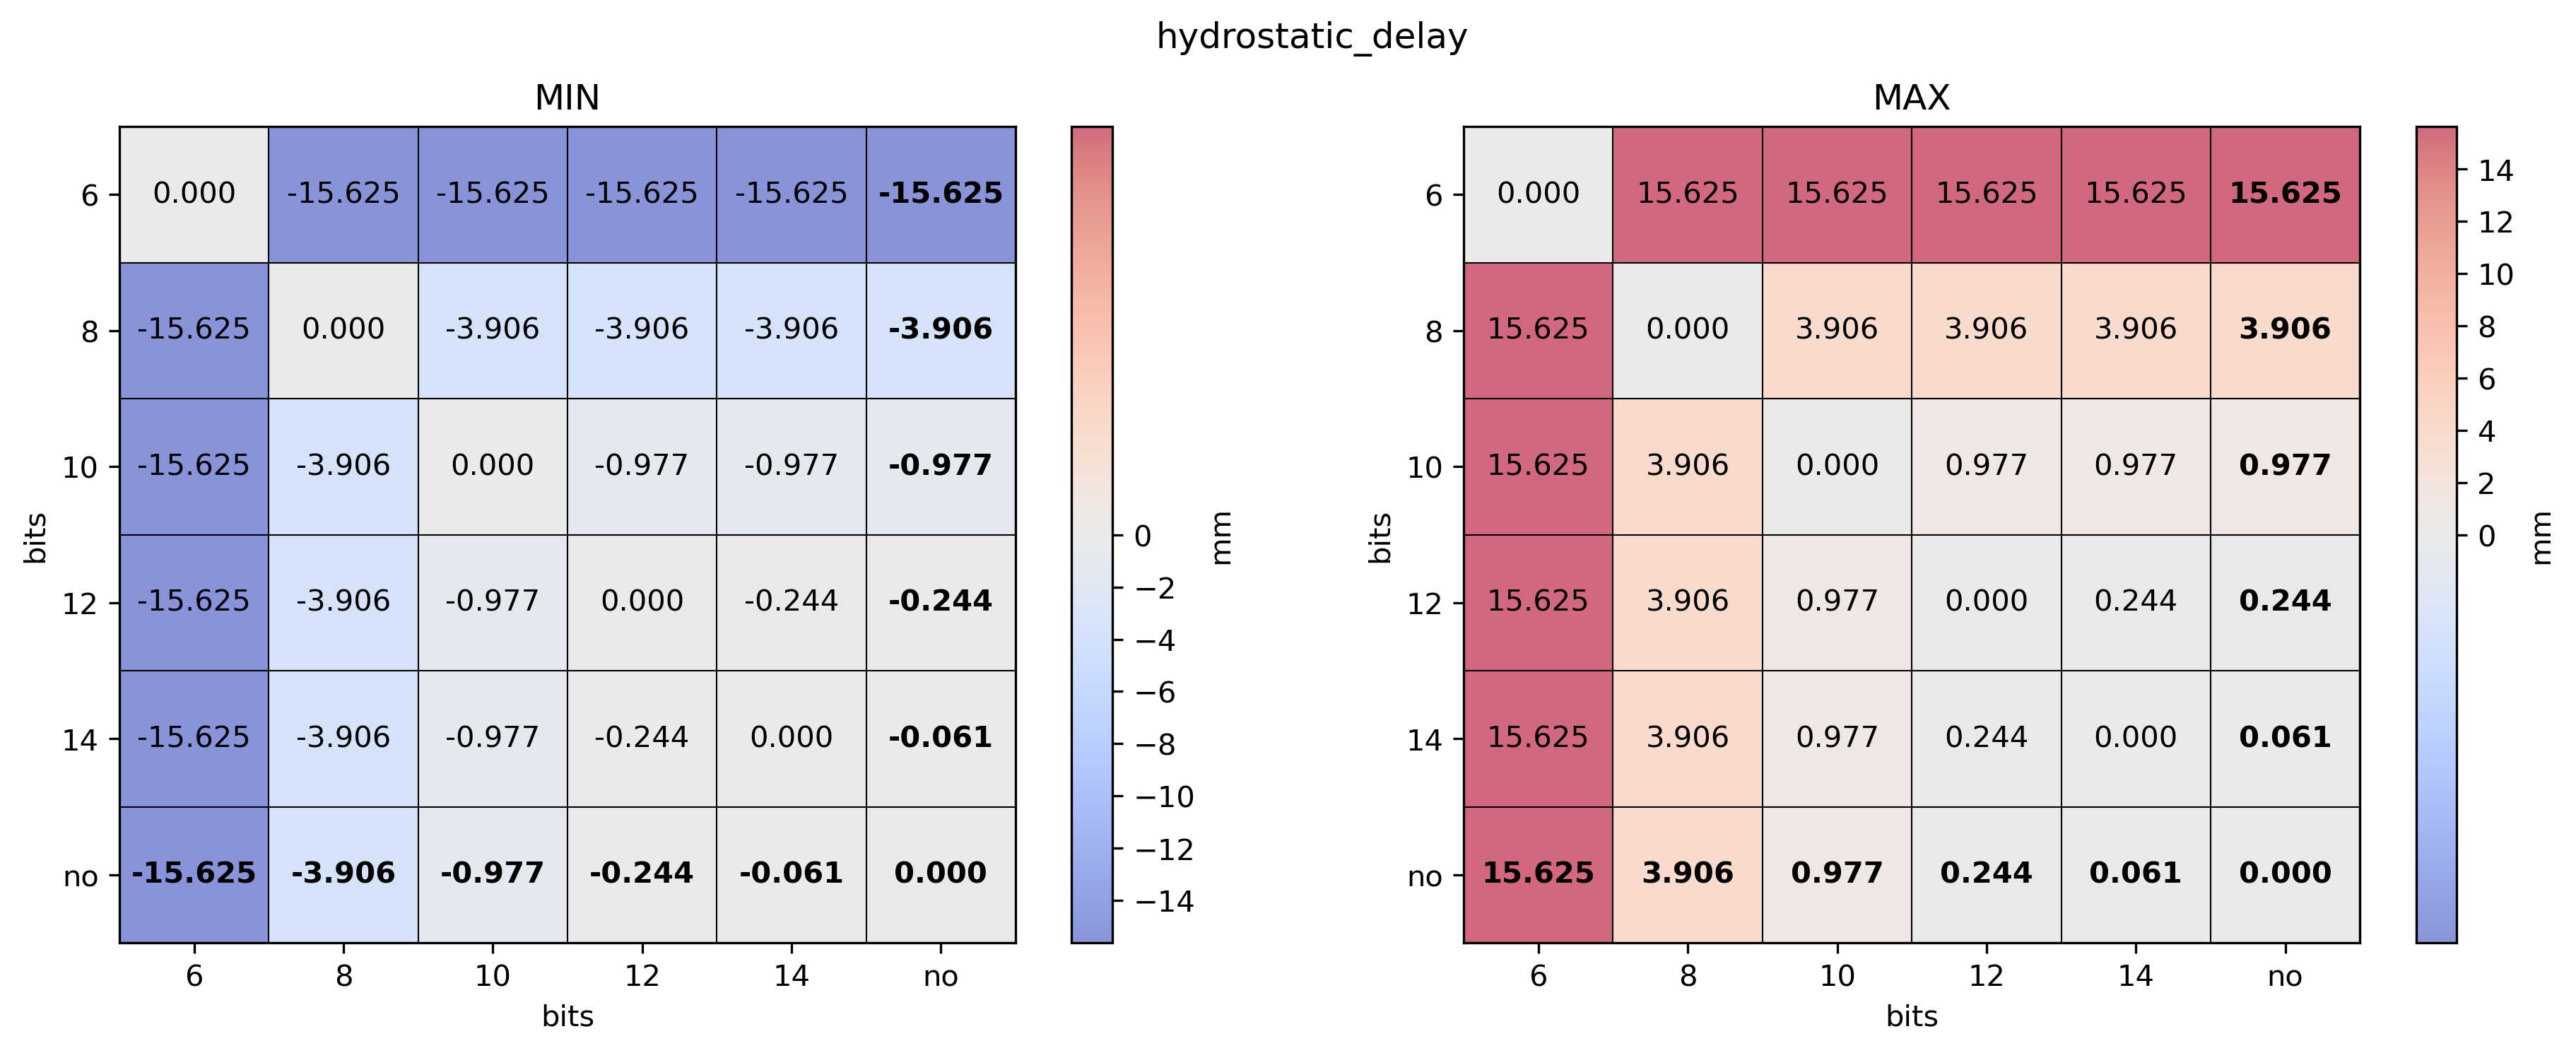

In [201]:
df_min = get_cross_tab(ds_dict, metric='min', layer='hydrostatic_delay')
df_max = get_cross_tab(ds_dict, metric='max', layer='hydrostatic_delay')
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=300)
ax[0] = _plot_crosstab(fig, ax[0], df_min), ax[0].set_title('MIN')
ax[1] = _plot_crosstab(fig, ax[1], df_max), ax[1].set_title('MAX')
fig.suptitle('hydrostatic_delay')

In [209]:
%%time
TROPO_PRODUCTS.wet_delay.keep_bits = 6
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 6
out_ds_6 = calculate_ztd(subset_ds3)

TROPO_PRODUCTS.wet_delay.keep_bits = 8
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 8
out_ds_8 = calculate_ztd(subset_ds3)

TROPO_PRODUCTS.wet_delay.keep_bits = 10
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 10
out_ds_10 = calculate_ztd(subset_ds3)

TROPO_PRODUCTS.wet_delay.keep_bits = 12
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 12
out_ds_12 = calculate_ztd(subset_ds3)

TROPO_PRODUCTS.wet_delay.keep_bits = 14
TROPO_PRODUCTS.hydrostatic_delay.keep_bits = 14
out_ds_14 = calculate_ztd(subset_ds3)

out_ds = calculate_ztd(subset_ds3, keep_bits=False)

# Get different round results
ds_dict = {'6': out_ds_6,
          '8': out_ds_8,
          '10': out_ds_10,
          '12': out_ds_12,
          '14': out_ds_14,
          'no': out_ds}

6
8
10
12
14
CPU times: user 4min 22s, sys: 3min 22s, total: 7min 44s
Wall time: 7min 35s


Text(0.5, 0.98, 'Wet_delay')

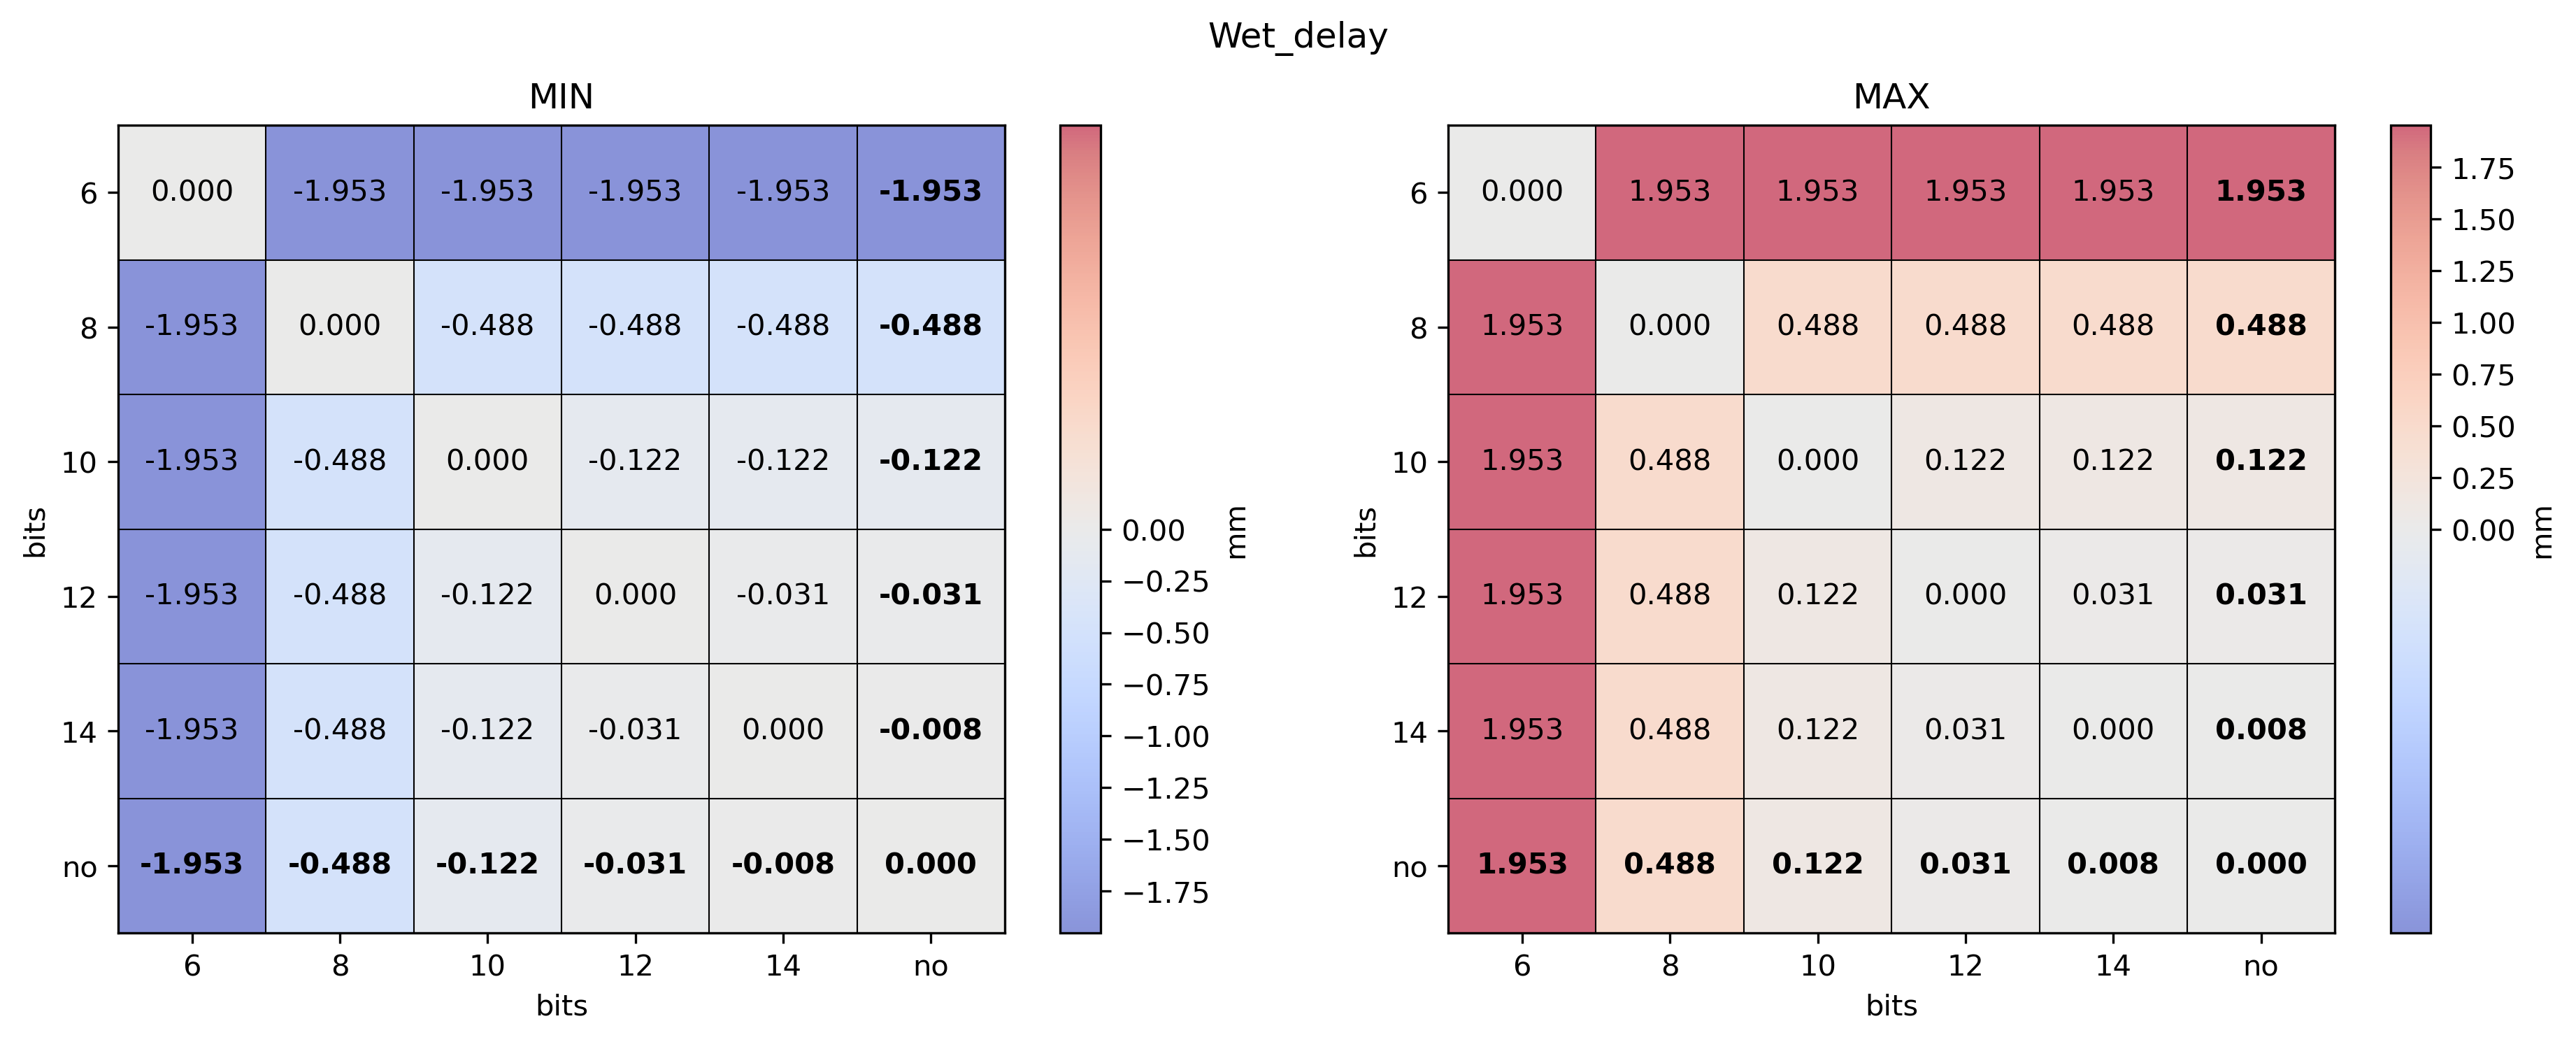

In [210]:
df_min = get_cross_tab(ds_dict, metric='min', layer='wet_delay')
df_max = get_cross_tab(ds_dict, metric='max', layer='wet_delay')
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=300)
ax[0] = _plot_crosstab(fig, ax[0], df_min), ax[0].set_title('MIN')
ax[1] = _plot_crosstab(fig, ax[1], df_max), ax[1].set_title('MAX')
fig.suptitle('Wet_delay')

Text(0.5, 0.98, 'hydrostatic_delay')

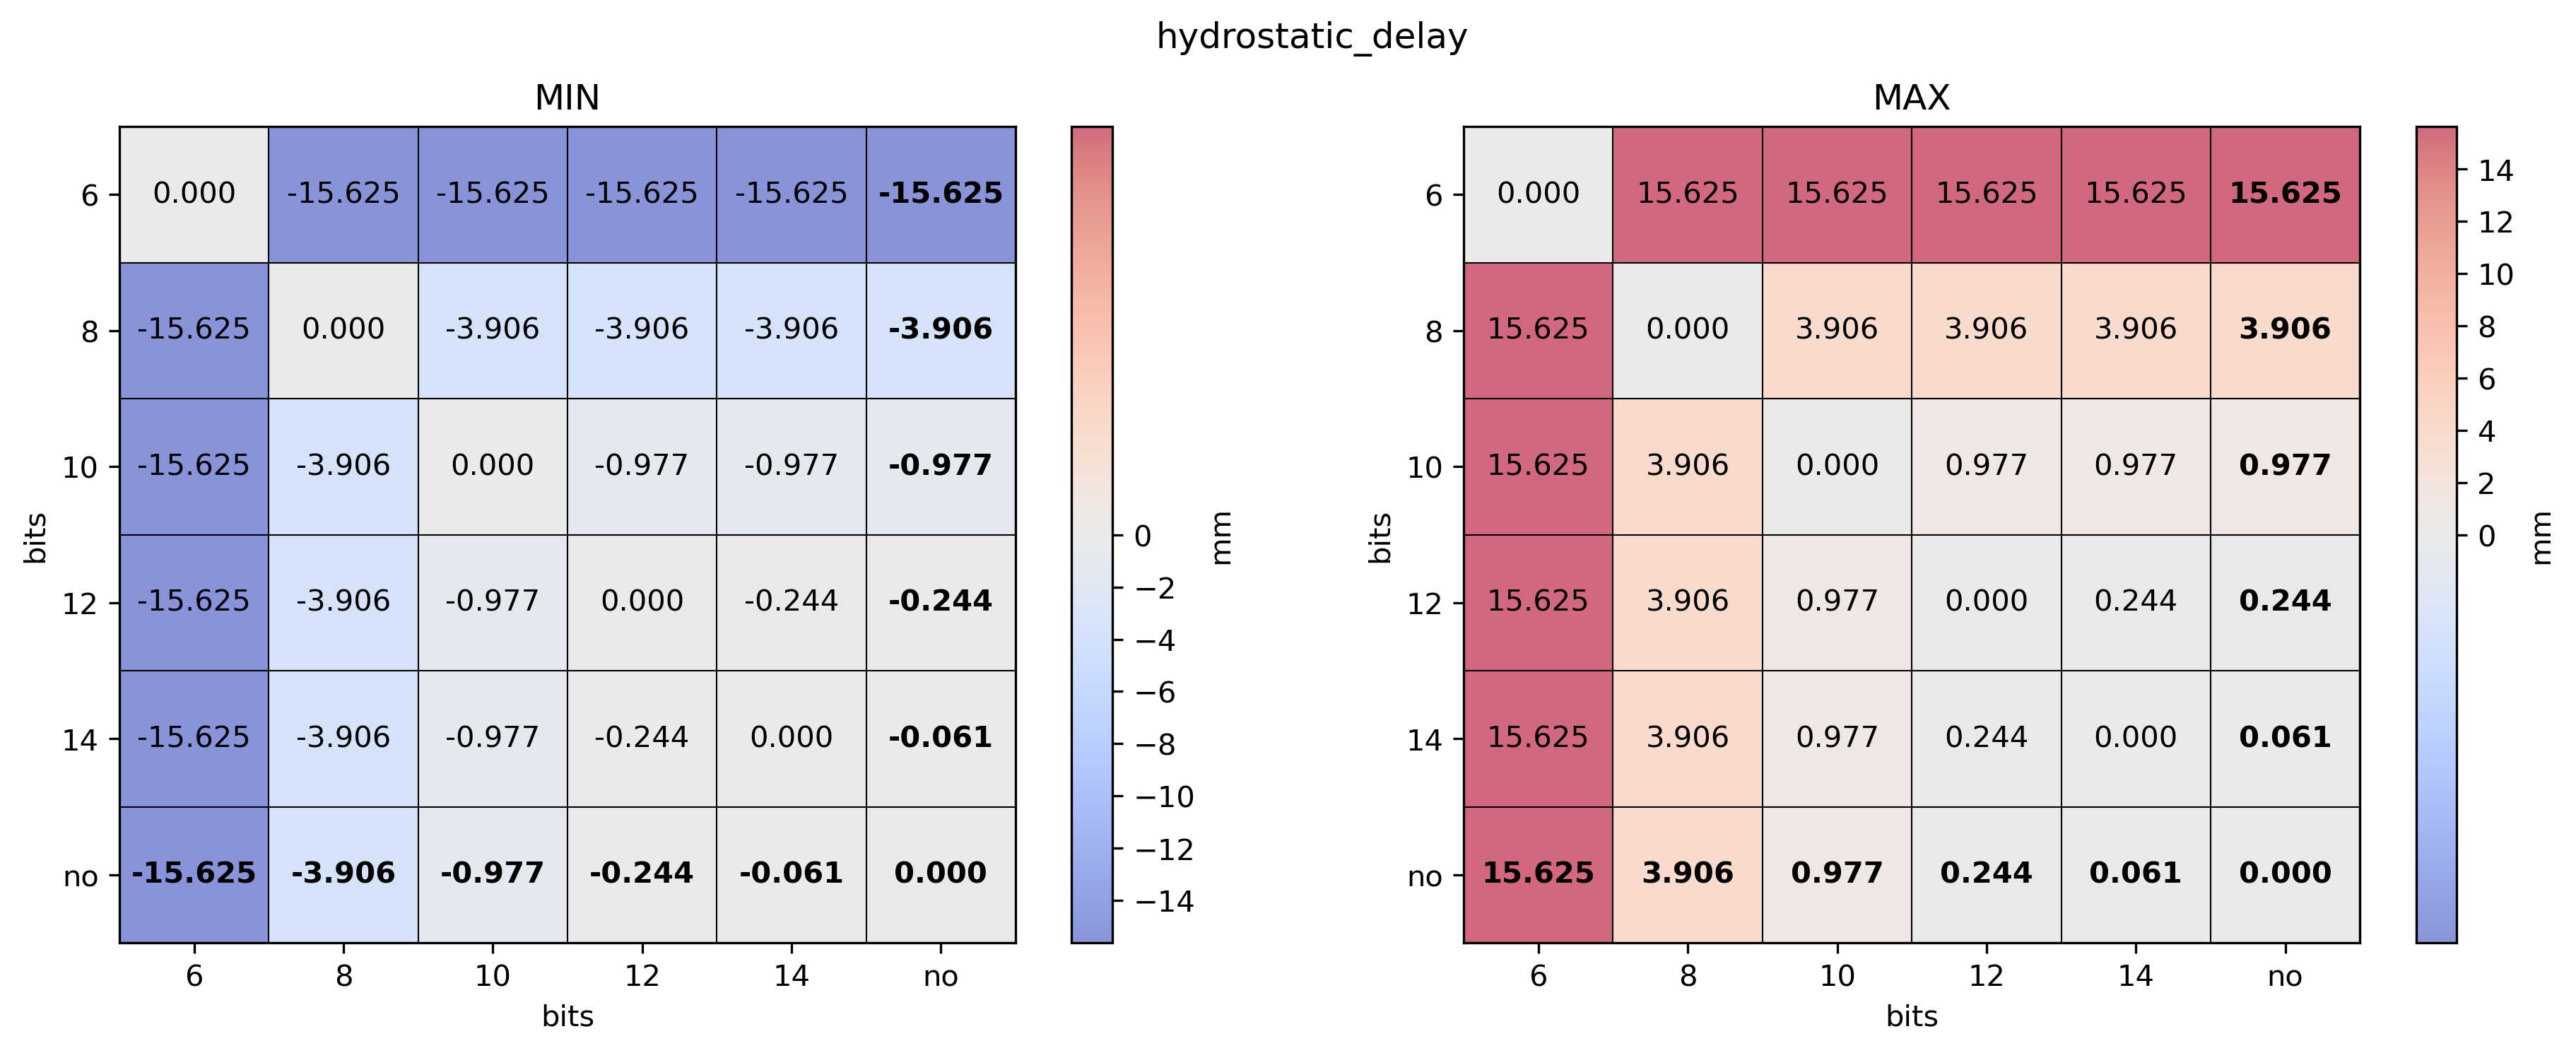

In [211]:
df_min = get_cross_tab(ds_dict, metric='min', layer='hydrostatic_delay')
df_max = get_cross_tab(ds_dict, metric='max', layer='hydrostatic_delay')
fig, ax = plt.subplots(1,2, figsize=(15,5), dpi=300)
ax[0] = _plot_crosstab(fig, ax[0], df_min), ax[0].set_title('MIN')
ax[1] = _plot_crosstab(fig, ax[1], df_max), ax[1].set_title('MAX')
fig.suptitle('hydrostatic_delay')